In [1]:
import warnings
warnings.filterwarnings('ignore')
import os    
import time
import torch 
import random 
import pathlib 
import torchvision     
import numpy as np  
import pandas as pd 
import splitfolders 
import torch.nn as nn   
import seaborn as sns   
import torch.utils.data
from tabulate import tabulate
from datetime import datetime  
from termcolor import colored  
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms as transforms


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# Dataset Overview
dir1 = 'Rice_Image_Dataset'
splitfolders.ratio(input=dir1, output='imgs', seed=42, ratio=(0.7, 0.15, 0.15))
dir2 = pathlib.Path('imgs')

Copying files: 75000 files [01:29, 834.17 files/s] 


In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load datasets
batch_size = 32
train_ds = torchvision.datasets.ImageFolder(os.path.join(dir2, 'train'), transform=transform)
val_ds = torchvision.datasets.ImageFolder(os.path.join(dir2, 'val'), transform=transform)
test_ds = torchvision.datasets.ImageFolder(os.path.join(dir2, 'test'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

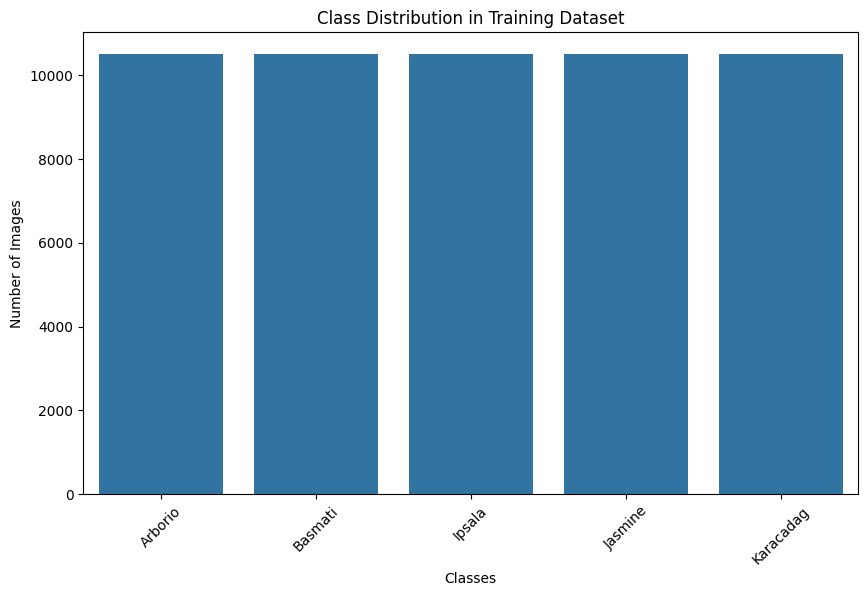

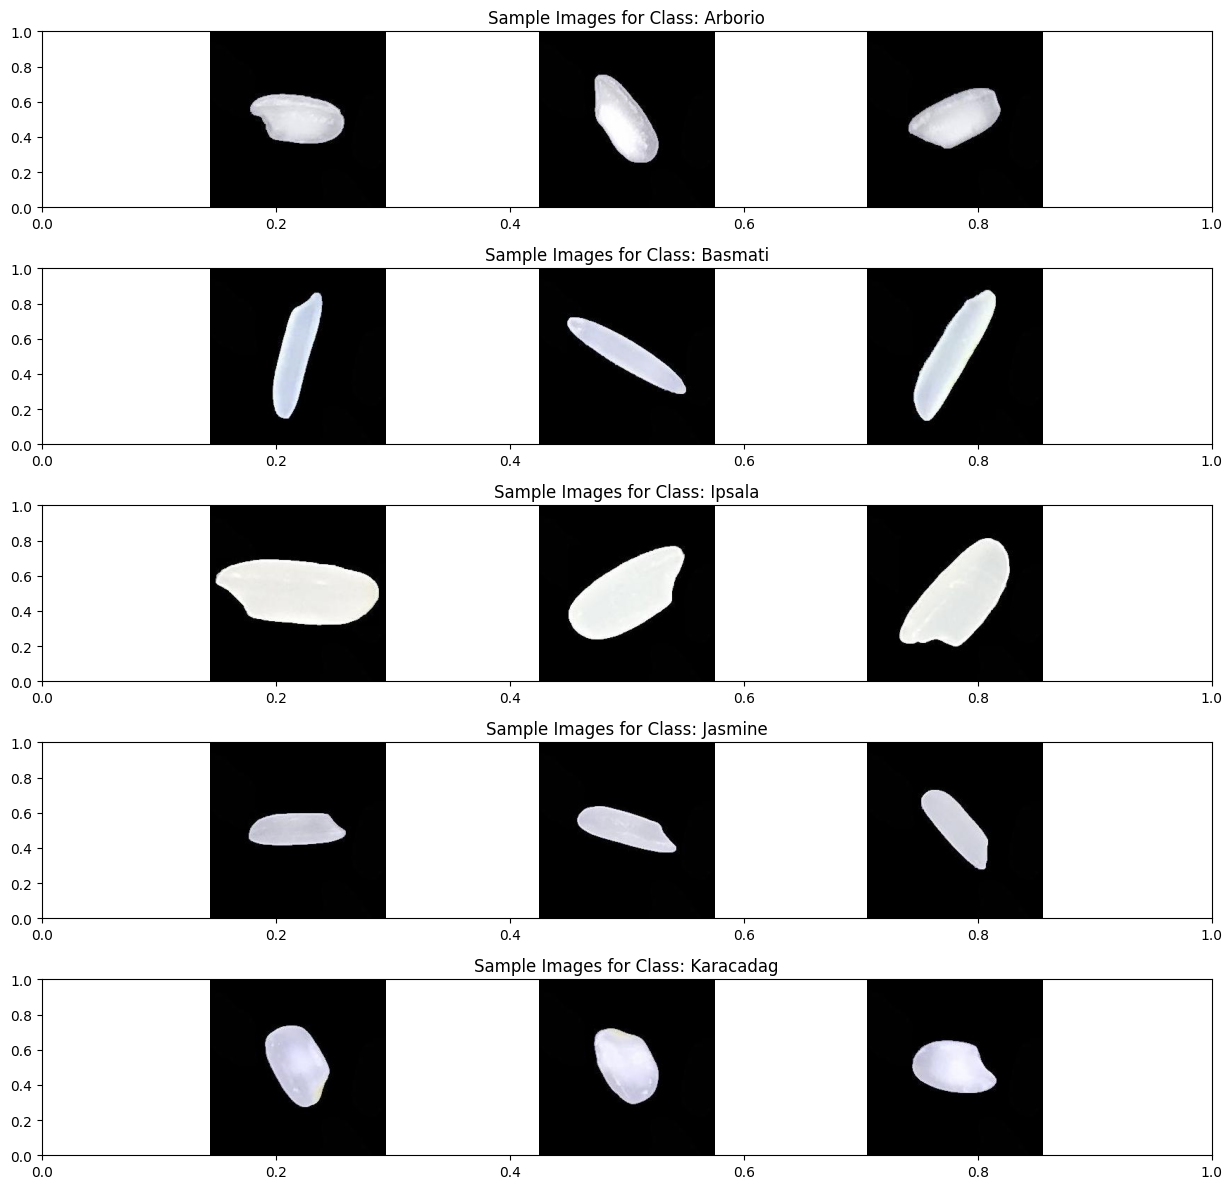

In [13]:

# Count the number of images in each class
class_counts = [0] * len(train_ds.classes)
for _, label in train_ds:
    class_counts[label] += 1

# Create a DataFrame for better visualization
class_distribution = pd.DataFrame({
    'Class': train_ds.classes,
    'Count': class_counts
})

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_distribution)
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.xlabel('Classes')
plt.show()


# Plot sample images from each class
def plot_sample_images_per_class(dataset, num_images=3):
    plt.figure(figsize=(12, 12))
    classes = dataset.classes
    class_indices = {cls: [] for cls in range(len(classes))}

    # Group indices by class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    for cls in range(len(classes)):
        plt.subplot(len(classes), 1, cls + 1)  # One row per class
        plt.title(f'Sample Images for Class: {classes[cls]}')
        for i in range(num_images):
            if i < len(class_indices[cls]):  # Check if there are enough samples
                img, _ = dataset[class_indices[cls][i]]
                img = img.permute(1, 2, 0)  # Change shape for plotting
                img = img * 0.5 + 0.5  # Unnormalize
                plt.subplot(len(classes), num_images, cls * num_images + i + 1)
                plt.imshow(img.numpy())
                plt.axis('off')
        plt.tight_layout()

    plt.show()

# Call the function to plot sample images for each class
plot_sample_images_per_class(train_ds)


In [6]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, unique_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(128 * 29 * 29, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, unique_classes)
        )
    
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [7]:
# Initialize model
unique_classes = len(train_ds.classes)
model = CNN(unique_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=107648, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [8]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
num_epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, n_correct_train, n_total_train = 0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted_labels = torch.max(y_pred, 1)
        n_correct_train += (predicted_labels == labels).sum().item()
        n_total_train += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(n_correct_train / n_total_train)
    
    # Validation phase
    model.eval()
    val_loss, n_correct_val, n_total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            val_loss += loss.item()
            _, predicted_labels = torch.max(y_pred, 1)
            n_correct_val += (predicted_labels == labels).sum().item()
            n_total_val += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(n_correct_val / n_total_val)

    # Print metrics for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print('-' * 50)
    print(f'Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accs[-1]:.4f}')
    print(f'Validation Loss: {val_losses[-1]:.4f} | Validation Accuracy: {val_accs[-1]:.4f}')
    print('-' * 50)


Epoch [1/5]
--------------------------------------------------
Train Loss: 0.1311 | Train Accuracy: 0.9543
Validation Loss: 0.0417 | Validation Accuracy: 0.9897
--------------------------------------------------
Epoch [2/5]
--------------------------------------------------
Train Loss: 0.0448 | Train Accuracy: 0.9860
Validation Loss: 0.0369 | Validation Accuracy: 0.9877
--------------------------------------------------
Epoch [3/5]
--------------------------------------------------
Train Loss: 0.0309 | Train Accuracy: 0.9906
Validation Loss: 0.0120 | Validation Accuracy: 0.9969
--------------------------------------------------
Epoch [4/5]
--------------------------------------------------
Train Loss: 0.0281 | Train Accuracy: 0.9919
Validation Loss: 0.0121 | Validation Accuracy: 0.9967
--------------------------------------------------
Epoch [5/5]
--------------------------------------------------
Train Loss: 0.0253 | Train Accuracy: 0.9925
Validation Loss: 0.0097 | Validation Accuracy

In [11]:
# Evaluate the model on the test set
model.eval()
test_loss, total_correct, total_samples = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        test_loss += loss.item()
        _, predicted_classes = torch.max(predictions, 1)
        total_correct += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = total_correct / total_samples
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Classification report
y_true, y_pred = [], []
for images, labels in test_loader:
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=train_ds.classes))

Test Loss: 0.0094, Test Accuracy: 0.9973
              precision    recall  f1-score   support

     Arborio       0.99      1.00      1.00      2250
     Basmati       1.00      1.00      1.00      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      1.00      1.00      2250
   Karacadag       1.00      1.00      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250



In [14]:

model_save_path = 'cnn_rice_classifier.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Model saved to cnn_rice_classifier.pth
